<a href="https://www.kaggle.com/code/lonnieqin/digits-generation-with-gan?scriptVersionId=116098672" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Digits Generation with GAN
## Import Packages

In [1]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import time

2023-01-11 14:53:28.984365: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


## Utilities

In [2]:
def sample_images(images, row_count, column_count):
    fig, axs = plt.subplots(row_count, column_count, figsize=(10,10))
    for i in range(row_count):
        for j in range(column_count):
            axs[i,j].imshow(images[i * column_count + j])
            axs[i,j].axis('off')
    plt.show()

In [3]:
def genrate_images(generator,row_count, column_count):
    fake_images = generator(tf.random.normal([row_count * column_count, random_normal_dimensions]))
    sample_images(fake_images, row_count, column_count)

## Import Datasets

In [4]:
batch_size = 100
random_normal_dimensions = 32
n_epochs = 10

In [5]:
def preproces_image(item):
    image = item["image"]
    image = tf.cast(image, "float")  / 255.0
    image =tf.reshape(image, (28, 28))
    return image

In [6]:
dataset = tfds.load("mnist", split='train', as_supervised=False).map(preproces_image).shuffle(1024).batch(batch_size, drop_remainder=True).prefetch(1).repeat(n_epochs)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


2023-01-11 14:53:35.053882: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-11 14:53:35.057872: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-01-11 14:53:35.129932: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-11 14:53:35.130693: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2023-01-11 14:53:35.130750: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2023-01-11 14:53:35.181092: I tensorflow/stream_executor/platform/def

## Build the Generator

In [7]:
tf.keras.backend.clear_session()

In [8]:
generator = keras.models.Sequential([                                 
    keras.layers.Dense(64, activation="selu", input_shape=[random_normal_dimensions]),
    keras.layers.Dense(128, activation="selu"),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

In [9]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                2112      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_2 (Dense)              (None, 784)               101136    
_________________________________________________________________
reshape (Reshape)            (None, 28, 28)            0         
Total params: 111,568
Trainable params: 111,568
Non-trainable params: 0
_________________________________________________________________


## Build the Discriminator

In [10]:
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(128, activation="selu"),
    keras.layers.Dense(64, activation="selu"),
    keras.layers.Dense(1, activation="sigmoid")
])

In [11]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 108,801
Trainable params: 108,801
Non-trainable params: 0
_________________________________________________________________


## Build the GAN

In [12]:
gan = keras.Sequential([generator, discriminator])

In [13]:
gan.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (None, 28, 28)            111568    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 108801    
Total params: 220,369
Trainable params: 220,369
Non-trainable params: 0
_________________________________________________________________


In [14]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

## Train the Model

2023-01-11 14:53:38.545029: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-01-11 14:53:38.550087: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000170000 Hz
2023-01-11 14:53:38.780215: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2023-01-11 14:53:39.767873: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11


ETA: 165.16s


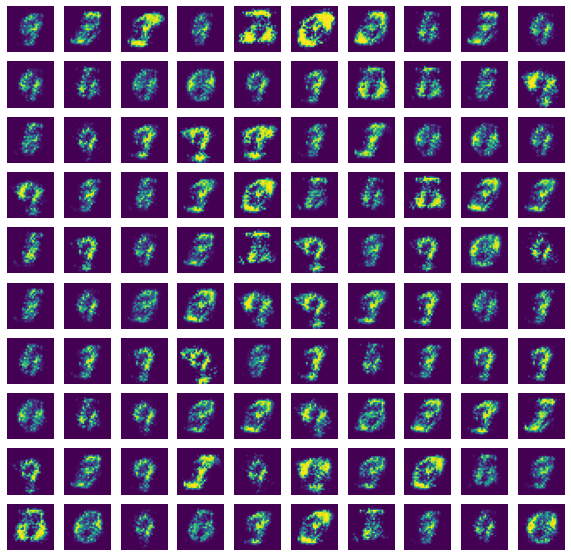

ETA: 136.43s


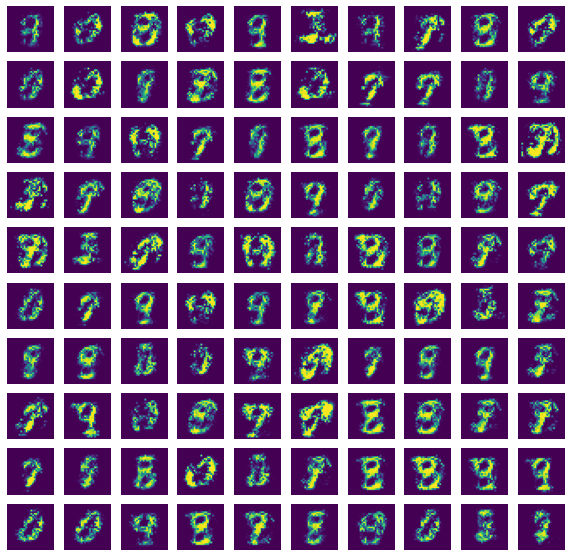

ETA: 116.63s


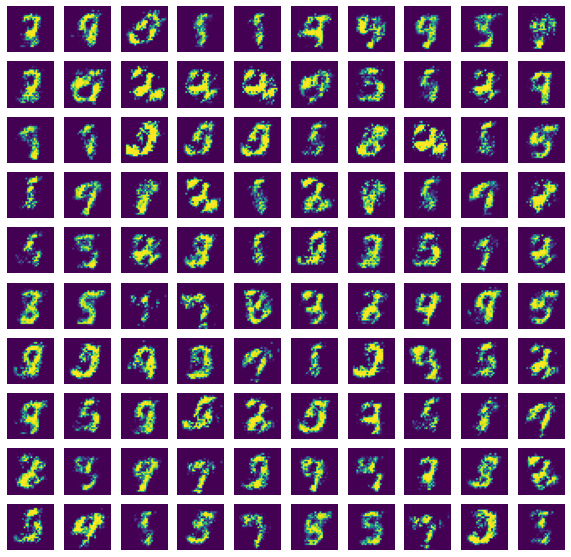

ETA: 100.82s


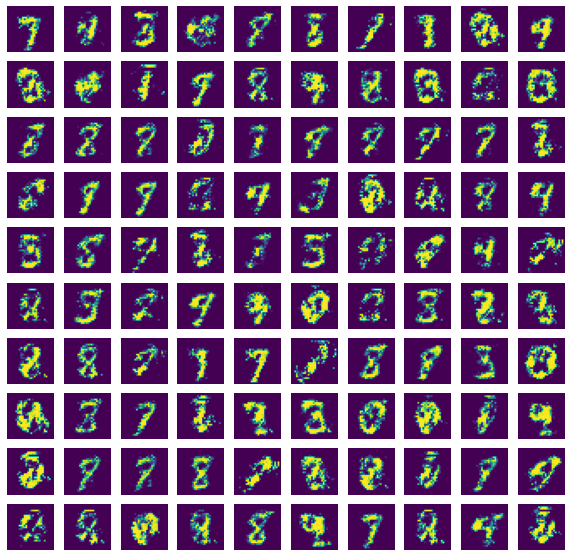

ETA: 86.70s


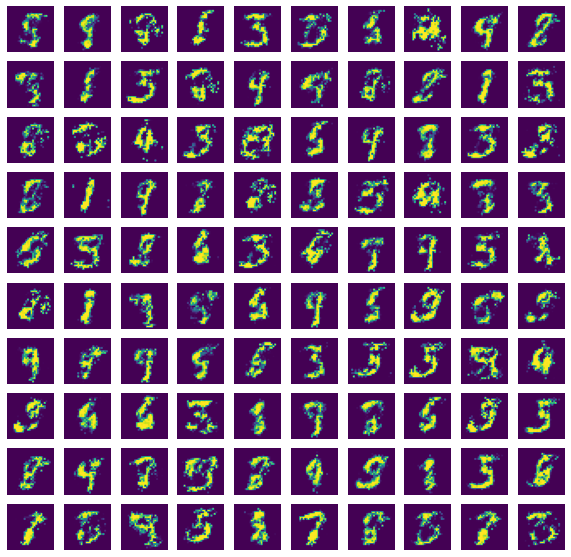

ETA: 72.94s


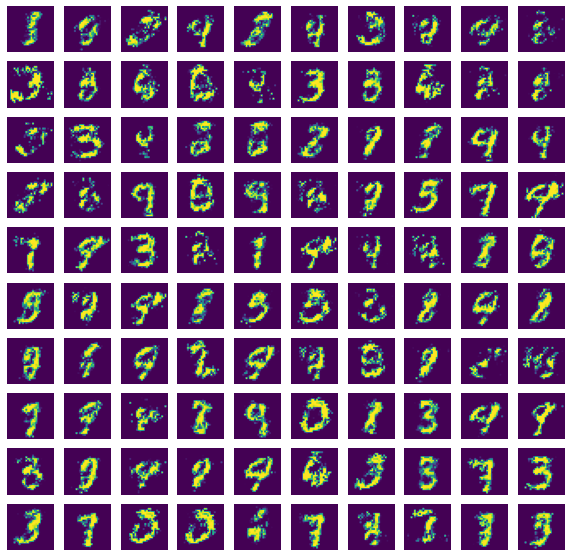

ETA: 60.29s


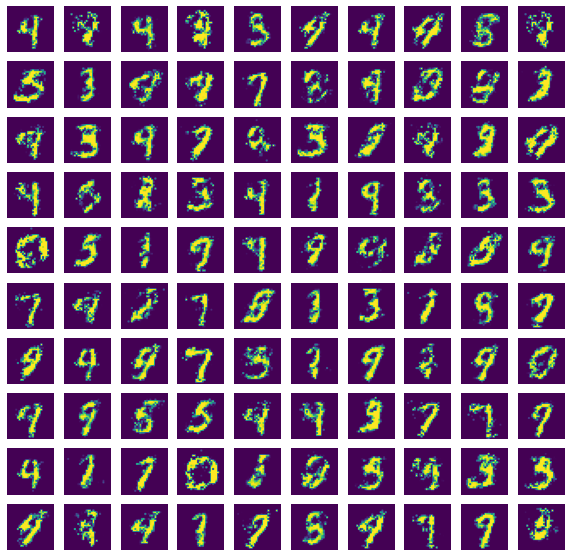

ETA: 48.09s


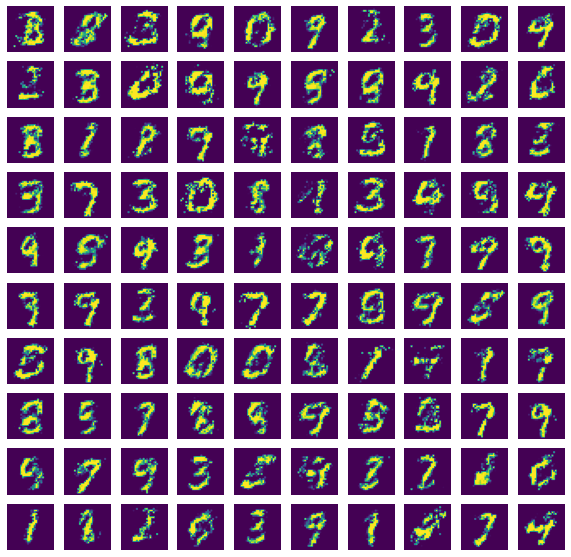

ETA: 35.79s


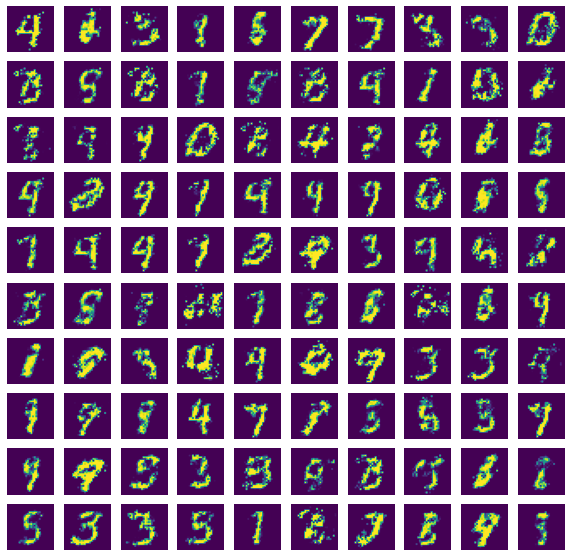

ETA: 23.69s


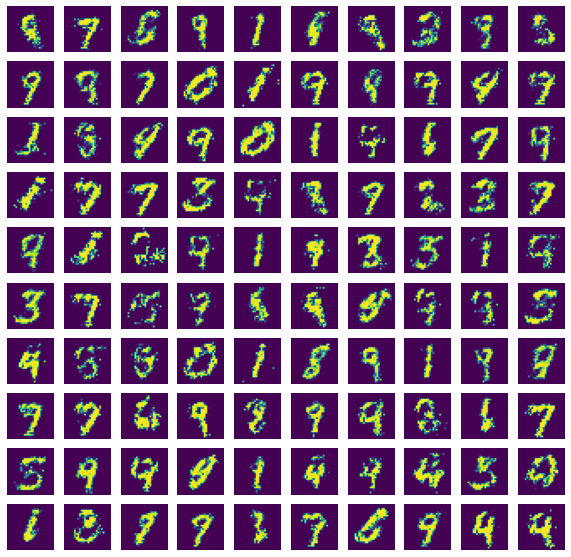

ETA: 11.82s


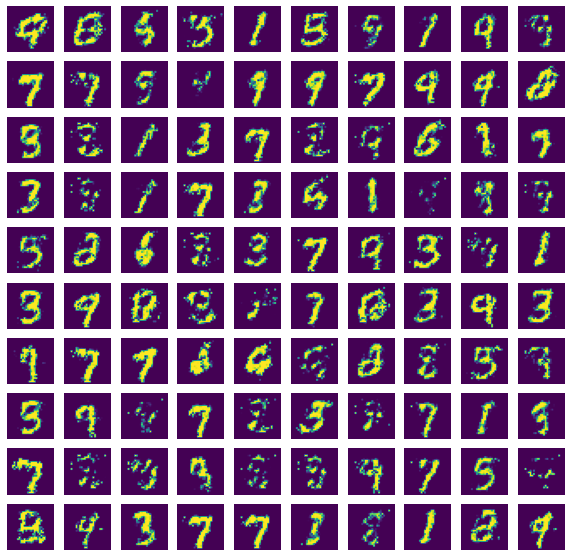

In [15]:
begin = time.time()
current_traning_images = 0
total = 60000 * n_epochs
i = 0
for real_images in dataset:
    noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])
    fake_images = generator(noise)
    current_traning_images += fake_images.shape[0]
    mixed_images = tf.concat([fake_images, real_images], axis=0)
    discriminator_labels = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
    discriminator.trainable = True
    discriminator.train_on_batch(mixed_images, discriminator_labels)
    noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])
    generator_labels = tf.constant([[1.]] * batch_size)
    discriminator.trainable = False
    gan.train_on_batch(noise, generator_labels)
    if i > 0 and i % 500 == 0:
        current_time = time.time() - begin
        ETA = current_time / current_traning_images * total - current_time
        print("ETA: %.2fs"% (ETA))
        genrate_images(generator,10, 10)
    i += 1

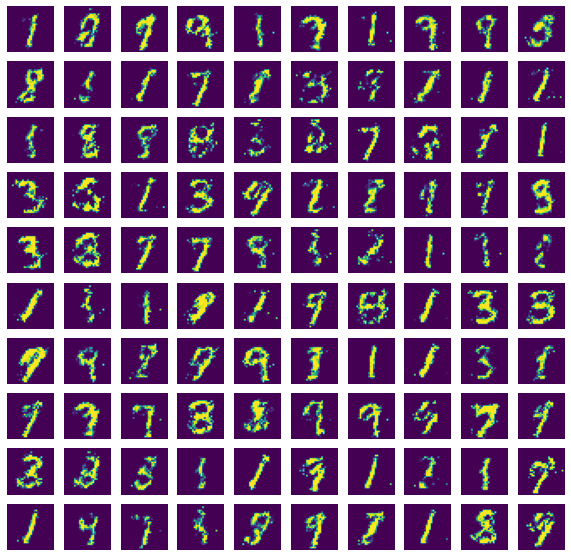

In [16]:
genrate_images(generator,10, 10)

## Evaluation

In [17]:
sample_count = 512
noise = tf.random.normal(shape=[sample_count, random_normal_dimensions])
fake_images = generator(noise)
probs = discriminator.predict(fake_images)
y_true = np.array([0.0] * sample_count)
y_pred = np.array(probs > 0.5, dtype=int)

### BCE

In [18]:
bce = tf.keras.metrics.BinaryCrossentropy()(y_true, y_pred)
print("BCE:%.2f"%(bce))

BCE:1.38


## Accuracy

This means that there is 82% of chance that Discriminator can classify the images generated by Generator fake.

In [19]:
accuracy = tf.keras.metrics.Accuracy()(y_true, y_pred)
print("Accuracy:%.2f"%(accuracy))

Accuracy:0.91


## Save the Model

In [20]:
generator.save("generator.h5")

In [21]:
discriminator.save("discriminator.h5")

In [22]:
gan.save("gan.h5")